In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

> PS : Still new in NLP so I really appreciate any advice regarding the structure of the notebook.

<div style="color:white;display:fill;
            background-color:#00bbe0;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>Table of Contents</b></p>
</div>

<a id="toc"></a>

- [1.1 Importing Libraries and Data](#1)

        
- [2.1 EDA](#2)


- [3.1 Text Preprocessing](#3)


- [4.1 Model Creatiion and Training](#4)
    - 4.2 Splitting Train and Test datasets
    - 4.3 Importing transformers
    - 4.4 Bert Tokenizer creation
    - 4.5 Datasets creation for train and test using tensorflow and tokenizer
    - 4.6 Bert Model Creation
    - 4.7 Training


- [5.1 Prediction and Submission](#5)



<a id="1"></a>

<div style="color:white;display:fill;
            background-color:#00bbe0;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>1.1 Importing Libraries and Data</b></p>
</div>

* importing bert offline model from huggingface-bert-variants kaggle dataset

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='darkgrid', font_scale=1)
path='/Users/kpathak/Library/CloudStorage/OneDrive-ManhattanAssociates/kpathak/ESSAY_COMP'

train_df = pd.read_csv(path+'/train.csv.zip')
test_df = pd.read_csv(path+'/test.csv')

# Checking for null values
train_df.isnull().sum() ,train_df.shape

(text_id        0
 full_text      0
 cohesion       0
 syntax         0
 vocabulary     0
 phraseology    0
 grammar        0
 conventions    0
 dtype: int64,
 (3911, 8))

In [24]:
train_df.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


In [4]:
bert_path = path+'/uncased_L-12_H-768_A-12'

<a id="2"></a>

<div style="color:white;display:fill;
            background-color:#00bbe0;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>2.1 EDA</b></p>
</div>



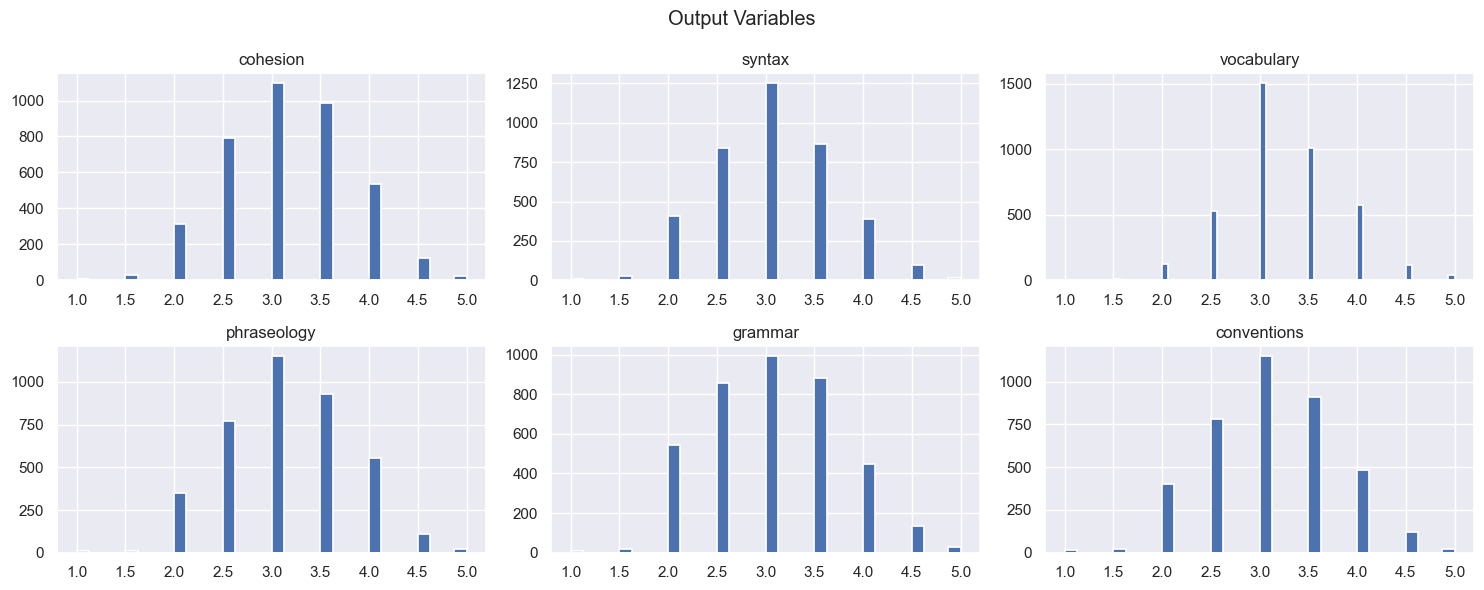

In [5]:
targets = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']

fig, axes = plt.subplots(2, len(targets)//2, figsize=(15,6))

for i, target in enumerate(targets):
    ax = axes.flat[i]
    sns.histplot(x=target, data=train_df, linewidth=1.25, alpha=1, ax=ax, zorder=2)
    ax.set_title(target)
    ax.set(xlabel=None, ylabel=None)
    
fig.suptitle('Output Variables')
plt.tight_layout()
plt.show()


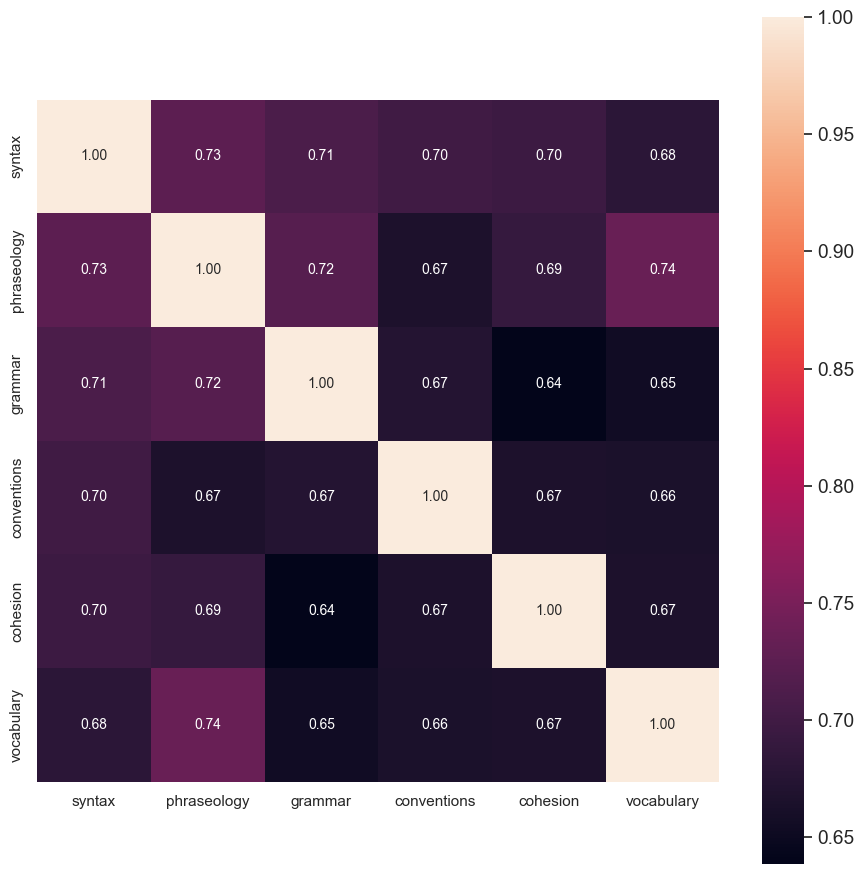

Index(['syntax', 'phraseology', 'grammar', 'conventions', 'vocabulary'], dtype='object')

In [6]:
k = len(train_df.columns) #number of variables for heatmap
f,ax = plt.subplots(figsize=(11, 11))
cols = train_df.corr().abs().nlargest(k, 'syntax')['syntax'].index
cm = np.corrcoef(train_df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()
cols = cols.drop('cohesion')
cols

<a id="3"></a>

<div style="color:white;display:fill;
            background-color:#00bbe0;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>3.1 Text Preprocessing</b></p>
</div>

In [7]:
# Merging Train and Test Data
ntrain = train_df.shape[0]
ntest = test_df.shape[0]
all_data = pd.concat((train_df, test_df)).reset_index(drop=True)
all_data.drop(['text_id'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (3914, 7)


In [12]:
import string
import nltk
from nltk.corpus import stopwords
PUNCT_TO_REMOVE = string.punctuation
STOPWORDS = set(stopwords.words('english'))
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re

# Create an instance of a PorterStemmer object
lemmatizer = WordNetLemmatizer()

def preprocess(text) : 
    #Using cased model so not lowering 
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+','', text)
    text = re.sub(r'@[0-9a-zA-Z]*\W+',' ' , text)
    #text = re.sub(r'\.','[SEP]' , text)
    
    #text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'\#', ' ', text)
    text = re.sub(r'\'', ' ', text)
        
    #text = text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))
    #text = [word for word in str(text).split() if word not in STOPWORDS]

    # For each token of each text, we generated its stem 
    #text = [lemmatizer.lemmatize(token) for token in text]
    #text = ' '.join(text)
    list_text = text.split()
    text = ' '.join(list_text[:512])
    return text

In [13]:
test = 'Our \'fffff\'Deeds are the . Reason of @insta this #earthquake M'
print(preprocess(test))

our fffff deeds are the . reason of this earthquake m


In [14]:
all_data['full_text'] = all_data['full_text'].apply(lambda text : preprocess(text))

<a id="4"></a>

<div style="color:white;display:fill;
            background-color:#00bbe0;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>4.1 Model Creation and Training</b></p>
</div>

#### 4.2 Splitting Train and Test datasets

In [15]:
train_data = all_data[:ntrain].copy()
test_data = all_data[ntrain:]

train_data.shape , test_data.shape

((3911, 7), (3, 7))

In [16]:
BATCH_SIZE = 6

MAX_LEN = max(len(x.split()) for x in all_data['full_text'])
print(MAX_LEN)

512


#### 4.3 Importing transformers

In [19]:
import tensorflow as tf
from transformers import BertTokenizer , TFBertModel 

AUTO = tf.data.experimental.AUTOTUNE

#### 4.3 Bert Tokenizer creation

In [20]:
tokenizer = BertTokenizer.from_pretrained(bert_path)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'BertTokenizer'.


#### 4.4 Datasets creation for train and test using tensorflow and tokenizer

In [21]:
def encode(input_text):
    inputs = tokenizer.batch_encode_plus(input_text,padding='max_length',max_length=MAX_LEN, truncation=True)
    return inputs

In [23]:
train_input = encode(train_data['full_text'].values.tolist())['input_ids']
# train_input

In [25]:

train_data_ds = (
    tf.data.Dataset
    .from_tensor_slices((train_input,train_data.drop('full_text', axis = 1)))
    .repeat()
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

2022-10-04 17:22:30.712902: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [26]:
testing_input = encode(test_data.full_text.values.tolist())['input_ids']

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(testing_input)
    .batch(BATCH_SIZE)
)

#### Helper functions

In [27]:
# Custom error function MCRMSE : column wise root mean squared eoor
def MCRMSE(y_true, y_pred):
    colwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=1)
    return tf.reduce_mean(tf.sqrt(colwise_mse), axis=-1, keepdims=True)

In [36]:
def create_model():
    bert_encoder = TFBertModel.from_pretrained('bert-base-uncased')
    input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_word_ids")

    embedding = bert_encoder(input_word_ids)[0]
    x = tf.keras.layers.GlobalAveragePooling1D()(embedding)
    x = tf.keras.layers.LayerNormalization()(x)
    #Output layer without activation function because regression task
    output = tf.keras.layers.Dense(6,)(x)

    model = tf.keras.models.Model(inputs=input_word_ids, outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss=MCRMSE
                  , metrics=MCRMSE)

    return model

#### 4.5 Bert Model creation

In [37]:
model= create_model()
model.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer)  [(None, 512)]            0         
                                                                 
 tf_bert_model (TFBertModel)  TFBaseModelOutputWithPoo  109482240
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             512, 768),                          
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                             

In [38]:
import  gc
gc.collect()

22742

In [39]:
BATCH_SIZE

6

#### 4.6 Training

In [40]:
from tensorflow.keras.callbacks import EarlyStopping

callback = tf.keras.callbacks.EarlyStopping(monitor='MCRMSE', patience = 2 ,restore_best_weights=True)

history = model.fit(
                    train_data_ds, 
                    steps_per_epoch= train_data.shape[0]//BATCH_SIZE,
                    batch_size = BATCH_SIZE,
                    epochs= 3,
                    verbose = 1,
                    shuffle= True,
                    callbacks=[callback],
                       )

Epoch 1/3
651/651 [==============================] - 19388s 30s/step - loss: 0.5241 - MCRMSE: 0.5241
Epoch 2/3
651/651 [==============================] - 49914s 77s/step - loss: 0.4594 - MCRMSE: 0.4594
Epoch 3/3
651/651 [==============================] - 27843s 43s/step - loss: 0.4328 - MCRMSE: 0.4328


<a id="5"></a>

<div style="color:white;display:fill;
            background-color:#00bbe0;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 4px;color:white;"><b>Prediction + Submission</b></p>
</div>

In [42]:
sub = pd.DataFrame({})
sub[['cohesion','syntax','vocabulary','phraseology','grammar','conventions']] = model.predict(test_dataset)
sub.to_csv('submission.csv',index=False)
sub

1/1 [==============================] - 11s 11s/step


,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,3.125286,2.872230,3.187831,3.126832,2.914896,2.907867
1,2.649934,2.493409,2.755910,2.298735,2.205299,2.798430
2,3.726249,3.612067,3.536789,3.471808,3.470615,3.840586


# 